In [491]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import umap
import os
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.stats import ttest_ind

import argparse
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingCAC

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari, silhouette_score
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import MultiHeadIDEC,  target_distribution
from utils import *

# Utils.py

In [730]:
## Utils.py
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import linear_sum_assignment as linear_assignment
from read_patients import get_aki

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

DATASETS = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'respiratory',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'kidney', 'infant', 'wid_mortality']

DATA_DIR = "/Users/shivin/Document/NUS/Research/Data"
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC"

def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def is_non_zero_file(fpath):
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0


class parameters(object):
    def __init__(self, parser):
        self.input_dim = -1
        self.dataset = parser.dataset
        
        # Training parameters
        self.lr = parser.lr
        self.alpha = float(parser.alpha)
        self.wd = parser.wd
        self.batch_size = parser.batch_size
        self.n_epochs = parser.n_epochs
        self.pre_epoch = parser.pre_epoch
        self.pretrain = parser.pretrain
        self.load_ae = parser.load_ae
        self.classifier = parser.classifier
        self.tol = parser.tol

        # Model parameters
        self.lamda = parser.lamda
        self.beta = parser.beta
        self.gamma = parser.gamma
        self.delta = parser.delta
        self.hidden_dims = parser.hidden_dims
        self.latent_dim = self.n_z = parser.n_z
        self.n_clusters = parser.n_clusters
        self.clustering = parser.clustering
        self.n_classes = parser.n_classes

        # Utility parameters
        self.device = parser.device
        self.log_interval = parser.log_interval
        self.pretrain_path = parser.pretrain_path + "/" + self.dataset + ".pth"


#######################################################
# Evaluate Critiron
#######################################################


def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row, col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row, col)]) * 1.0 / y_pred.size


def plot(model, X_train, y_train, X_test=None, y_test=None, labels=None):
    reducer = umap.UMAP(random_state=42)
#     idx = torch.Tensor(np.random.randint(0,len(X_train),\
#                         int(1*len(X_train)))).type(torch.LongTensor).to(device)
    idx = range(len(X_train))
    qs, latents_X = model(X_train[idx], output="latent")
    q_train = qs[0]
    y_train = y_train[idx]

    if labels is not None:
        cluster_id_train = labels[idx]
    else:
        cluster_id_train = torch.argmax(q_train, axis=1)

    X2 = reducer.fit_transform(latents_X.cpu().detach().numpy())

    print("Training data")

    c_clusters = [color[int(cluster_id_train[i])] for i in range(len(cluster_id_train))]
    c_labels = [color[int(y_train[i])] for i in range(len(cluster_id_train))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Clusters vs Labels')
    ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
    ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
    plt.show()
    if X_test is not None:
        qs, latents_test = model(X_test, output="latent")
        q_test = qs[0]
        X2 = reducer.transform(latents_test.cpu().detach().numpy())
        cluster_id_test = torch.argmax(q_test, axis=1)
        c_clusters = [color[int(cluster_id_test[i])] for i in range(len(cluster_id_test))]
        c_labels = [color[int(y_test[i])] for i in range(len(cluster_id_test))]

        print("Test data")
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

def get_dataset(DATASET, DATA_DIR):
    if DATASET == "cic":
        Xa = pd.read_csv(DATA_DIR + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(DATA_DIR + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(DATA_DIR + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()
        columns = cols

    elif DATASET == "titanic":
        X_train = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X_train.csv")
        columns = X_train.columns
        X_train = X_train.to_numpy()
        X_test = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()
    
    elif DATASET == "infant":
        X = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        y = y.astype(int)
        enc = OneHotEncoder(handle_unknown='ignore')
        X = enc.fit_transform(X).toarray()
    
    elif DATASET == "kidney":
        print("Fetching Kidney Dataset")
        data = get_aki(DATA_DIR)
        X = pd.concat(data,axis=1).T
        columns = X.columns

        data_columns = list(columns[1:90]) + ['y'] # get the columns which have data, not mask
        non_binary_columns = data_columns[:81] # only these columns have non-binary data fit for scaling

        X = X.fillna(0)
        X = X[data_columns]

        y = X['y'].to_numpy().astype(int)
        X = X.drop(columns=['y'])

        scaler = MinMaxScaler()
        X[non_binary_columns] = scaler.fit_transform(np.nan_to_num(X[non_binary_columns]))
        X = X.to_numpy()
        os.chdir(BASE_DIR)

    elif DATASET == "respiratory":
        print("Fetching Respiratory Dataset")
        data = get_aki(DATA_DIR)
        X = pd.concat(data,axis=1).T
        columns = X.columns

        data_columns = list(columns[1:90]) + ['y'] # get the columns which have data, not mask
        non_binary_columns = data_columns[:81] # only these columns have non-binary data fit for scaling

        X = X.fillna(0)
        X = X[data_columns]

        y = X['y'].to_numpy().astype(int)
        X = X.drop(columns=['y'])

        scaler = MinMaxScaler()
        X[non_binary_columns] = scaler.fit_transform(np.nan_to_num(X[non_binary_columns]))
        X = X.to_numpy()
        os.chdir(BASE_DIR)

    else:
        X = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(DATA_DIR + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
    return X, y, columns


def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    columns = ["feature_"+str(i) for i in range(n_features)]
    return X, np.array(Y).astype('int'), columns


def get_train_val_test_loaders(args):
    if args.dataset in DATASETS:
        if args.dataset != "kidney" and args.dataset != "respiratory":
            print("Loading Dataset ", args.dataset)
            if args.dataset == "synthetic":
                n_feat = 45
                X, y, columns = create_imbalanced_data_clusters(n_samples=5000,\
                       n_clusters=args.n_clusters, n_features = n_feat,\
                       inner_class_sep=0.2, outer_class_sep=2, seed=0)
                args.input_dim = n_feat

            elif args.dataset == "paper_synthetic":
                n_feat = 100
                X, y = paper_synthetic(2500, centers=4)
                args.input_dim = n_feat
                print(args.input_dim)

            else:
                X, y, columns = get_dataset(args.dataset, DATA_DIR)
                print(args.dataset)
                args.input_dim = X.shape[1]

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_val = sc.fit_transform(X_val)
            X_test = sc.fit_transform(X_test)
            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

        elif args.dataset == "kidney":
            print("Loading Kidney Train")
            X_train, y_train, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/train")
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            args.input_dim = X_train.shape[1]
            print(args.input_dim)

            print("Loading Kidney Test")
            X_test, y_test, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/test")

            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

        else:
            print("Loading Repiratory Train")
            X_train, y_train, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/ards/train")
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            args.input_dim = X_train.shape[1]
            print(args.input_dim)

            print("Loading Respiratory Test")
            X_test, y_test, columns = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/ards/test")

            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))
            
        train_loader = torch.utils.data.DataLoader(X_train_data_loader,
            batch_size=args.batch_size, shuffle=True)

        val_loader = torch.utils.data.DataLoader(X_val_data_loader,
            batch_size=args.batch_size, shuffle=True)

        test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
            batch_size=args.batch_size, shuffle=False)

        return columns, (X_train, y_train, train_loader), (X_val, y_val, val_loader), (X_test, y_test, test_loader)
    else:
        return None


def paper_synthetic(n_pts=1000, centers=4):
    X, y = make_blobs(n_pts, centers=centers)
    W = np.random.randn(10,2)
    U = np.random.randn(100,10)
    X1 = W.dot(X.T)
    X1 = X1*(X1>0)
    X2 = U.dot(X1)
    X2 = X2*(X2>0)
    return X2.T, y

In [851]:
import numpy as np
import torch

class EarlyStoppingCAC:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='./pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.ae.state_dict(), self.path+".pt")
        for j in range(model.n_clusters):
            torch.save(model.classifiers[j][0].state_dict(), self.path+"_"+str(j)+".pt")
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score, " named: ", self.path+".pt")
        model.ae.load_state_dict(torch.load(self.path+".pt"))
        for j in range(model.n_clusters):
            model.classifiers[j][0].load_state_dict(torch.load(self.path+"_"+str(j)+".pt"))
        return model


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='./pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path+".pt")
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score)
        model.load_state_dict(torch.load(self.path+".pt"))
        return model

In [698]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear
import torch
from utils import is_non_zero_file

class AE(nn.Module):
    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 input_dim, n_z):
        super(AE, self).__init__()

        # encoder
        self.enc_1 = Linear(input_dim, n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)

        self.z_layer = Linear(n_enc_3, n_z)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)

        self.x_bar_layer = Linear(n_dec_3, input_dim)

    def forward(self, x, output="decoded"):

        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        enc_h3 = F.relu(self.enc_3(enc_h2))

        z = self.z_layer(enc_h3)
        if output == "latent":
            return z

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        dec_h3 = F.relu(self.dec_3(dec_h2))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

def source_distribution(z, cluster_layer, alpha=1):
    q = 1.0 / (1.0 + torch.sum(
        torch.pow(z.unsqueeze(1) - cluster_layer, 2), 2) / alpha)
    q = q.pow((alpha + 1.0) / 2.0)
    q = (q.t() / torch.sum(q, 1)).t()
    return q

def pretrain_ae(model, train_loader, args):
    '''
    pretrain autoencoder
    '''
    print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    for epoch in range(50):
        total_loss = 0.
        for batch_idx, (x, _, _) in enumerate(train_loader):
            x = x.to(args.device)

            optimizer.zero_grad()
            x_bar, _ = model(x)
            loss = F.mse_loss(x_bar, x)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("Pretraining epoch {} loss={:.4f}".format(epoch,
                                            total_loss / (batch_idx + 1)))
        torch.save(model.state_dict(), args.pretrain_path)
    print("model saved to {}.".format(args.pretrain_path))

class NNClassifier(nn.Module):
    def __init__(self, args, input_dim, ae=None):
        super(NNClassifier, self).__init__()
        self.args = args
        self.n_classes = args.n_classes
        self.criterion = nn.CrossEntropyLoss(reduction='mean')
        self.ae = ae

        if self.ae == None:
            self.input_dim = input_dim
        else:
            self.input_dim = args.latent_dim
        if input_dim != None:
            self.input_dim = input_dim

        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, args.n_classes),
        )
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=args.lr)

    def forward(self, inputs):
        if self.ae == None:
            return self.classifier(inputs)
        else:
            input_z = self.ae(inputs, output="latent")
            return self.classifier(input_z)

    def fit(self, X_batch, y_batch):
        self.optimizer.zero_grad()
        self.classifier.train()
        y_pred = self.forward(X_batch.detach())
        train_loss = self.criterion(y_pred, y_batch)
        train_loss.backward()
        self.optimizer.step()
        return y_pred.detach().numpy(), train_loss.item()

class MultiHeadIDEC(nn.Module):
    def __init__(self,
                 n_enc_1,
                 n_enc_2,
                 n_enc_3,
                 n_dec_1,
                 n_dec_2,
                 n_dec_3,
                 args):
        super(MultiHeadIDEC, self).__init__()
        self.alpha = args.alpha
        self.pretrain_path = args.pretrain_path
        self.device = args.device
        self.n_clusters = args.n_clusters
        self.input_dim = args.input_dim
        self.n_z = args.n_z
        self.args = args

        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            input_dim=self.input_dim,
            n_z=self.n_z)

        # cluster layer
        self.cluster_layer = Parameter(torch.Tensor(self.n_clusters, self.n_z))
        self.p_cluster_layer = Parameter(torch.Tensor(self.n_clusters, self.n_z))
        self.n_cluster_layer = Parameter(torch.Tensor(self.n_clusters, self.n_z))
        torch.nn.init.xavier_normal_(self.cluster_layer.data)
        torch.nn.init.xavier_normal_(self.p_cluster_layer.data)
        torch.nn.init.xavier_normal_(self.n_cluster_layer.data)
        
        self.classifiers = []
        for _ in range(self.n_clusters):
            classifier = nn.Sequential(
                nn.Linear(self.n_z, 16),
                nn.ReLU(),
                nn.Linear(16, 8),
                nn.ReLU(),
                nn.Linear(8, args.n_classes),
            ).to(self.device)
            optimizer = torch.optim.Adam(classifier.parameters(), lr=args.lr)
            self.classifiers.append([classifier, optimizer])
            

    def pretrain(self, train_loader, path=''):
        print(path)
        if not is_non_zero_file(path):
            path = ''
        if path == '':
            pretrain_ae(self.ae, train_loader, self.args)
        else:
            # load pretrain weights
            self.ae.load_state_dict(torch.load(self.pretrain_path))
            print('load pretrained ae from', path)

    def predict(self, X_test):
        qs, z_test = self.forward(X_test)
        q_test = qs[0]
        cluster_ids = torch.argmax(q_test, axis=1)
        preds = torch.zeros((self.n_clusters, 2))
        for j in range(self.n_clusters):
            preds[j,:] = self.classifiers[cluster_ids[j]]
        return preds
        
    def forward(self, x, output="default"):
        x_bar, z = self.ae(x)
        # Cluster
        q = 1.0 / (1.0 + torch.sum(
            torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.alpha)
        q = q.pow((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()

        q_p = 1.0 / (1.0 + torch.sum(
            torch.pow(z.detach().unsqueeze(1) - self.p_cluster_layer, 2), 2) / self.alpha)
        q_p = q_p.pow((self.alpha + 1.0) / 2.0)
        q_p = (q_p.t() / torch.sum(q_p, 1)).t()

        q_n = 1.0 / (1.0 + torch.sum(
            torch.pow(z.detach().unsqueeze(1) - self.n_cluster_layer, 2), 2) / self.alpha)
        q_n = q_n.pow((self.alpha + 1.0) / 2.0)
        q_n = (q_n.t() / torch.sum(q_n, 1)).t()

        if output == "latent":
            return (q, q_p, q_n), z

        elif output == "classifier":
            preds = torch.zeros((len(z), 2))
            for j in range(len(z)):
                preds[j,:] = self.classifiers[j](z)
            return preds
        
        else:
            return z, x_bar, (q, q_p, q_n)

In [901]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 1.5,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 50,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",

# Model parameters
'lamda' : 1,
'beta' : 1, # KL loss/KM loss weight
'gamma' : 1, # Classification loss weight
'delta' : 0.1, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 8,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model'}
# 'pretrain_path': ''}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'kidney', 'infant', 'wid_mortality']

In [902]:
suffix = ""
suffix += args.dataset + "_"
suffix += str(args.n_clusters) + "_"
suffix += str(args.attention)

# column_names, train_data, val_data, test_data = get_train_val_test_loaders(args)
os.chdir(BASE_DIR)
X_train, y_train, train_loader = train_data
X_val, y_val, val_loader = val_data
X_test, y_test, test_loader = test_data

In [881]:
# X_train_kidney = X_train
# y_train_kidney = y_train
# train_loader_kidney = train_loader
# X_val_kidney = X_val
# y_val_kidney = y_val
# val_loader_kidney = val_loader
# X_test_kidney = X_test
# y_test_kidney = y_test
# test_loader_kidney = test_loader
X_train = X_train_kidney
y_train = y_train_kidney
train_loader = train_loader_kidney
X_val = X_val_kidney
y_val = y_val_kidney
val_loader = val_loader_kidney
X_test = X_test_kidney
y_test = y_test_kidney
test_loader = test_loader_kidney

NameError: name 'train_loader_kidney' is not defined

In [894]:
# X_train_resp = X_train
# y_train_resp = y_train
# train_loader_resp = train_loader
# X_val_resp = X_val
# y_val_resp = y_val
# val_loader_resp = val_loader
# X_test_resp = X_test
# y_test_resp = y_test
# test_loader_resp = test_loader
X_train = X_train_resp
y_train = y_train_resp
train_loader = train_loader_resp
X_val = X_val_resp
y_val = y_val_resp
val_loader = val_loader_resp
X_test = X_test_resp
y_test = y_test_resp
test_loader = test_loader_resp

In [903]:
print(column_names)
args.input_dim = X_train.shape[1]
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC"
os.chdir(BASE_DIR)
print(X_train.shape)

Index(['SAPS-I', 'SOFA', 'Length_of_stay', 'Age', 'Gender', 'Height', 'Weight',
       'CCU', 'CSRU', 'SICU',
       ...
       'SysABP_last', 'TroponinI_last', 'TroponinT_last', 'WBC_last',
       'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration',
       'MechVentLast8Hour', 'UrineOutputSum'],
      dtype='object', length=117)
(6750, 117)


In [886]:
print(sum(y_test)/len(y_test))

0.07235453723243895


# MultiHead IDEC

## Initialization

In [904]:
model = MultiHeadIDEC(
        n_enc_1=128,
        n_enc_2=64,
        n_enc_3=32,
        n_dec_1=32,
        n_dec_2=64,
        n_dec_3=128,
        args=args).to(args.device)

model.pretrain(train_loader, args.pretrain_path)

optimizer = Adam(model.parameters(), lr=args.lr)

# cluster parameter initiate
device = args.device
y = y_train
_, ori_hidden = model.ae(torch.Tensor(X_train).to(args.device))
_, ori_hidden_val = model.ae(torch.Tensor(X_val).to(args.device))

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
_ = kmeans.fit_predict(ori_hidden.data.cpu().numpy())

ori_cluster_indices = kmeans.labels_
original_cluster_centers = kmeans.cluster_centers_

ori_val_cluster_indices = kmeans.fit_predict(ori_hidden_val.data.cpu().numpy())

model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)

## Initialization ##
for i in range(args.n_clusters):
    cluster_idx = np.where(ori_cluster_indices == i)[0]
    cluster_idx_p = np.where(y[cluster_idx] == 1)[0]
    cluster_idx_n = np.where(y[cluster_idx] == 0)[0]
    hidden_p = ori_hidden[cluster_idx][cluster_idx_p]
    hidden_n = ori_hidden[cluster_idx][cluster_idx_n]

    model.p_cluster_layer.data[i,:] = torch.mean(hidden_p, axis=0)
    model.n_cluster_layer.data[i,:] = torch.mean(hidden_n, axis=0)

criterion = nn.CrossEntropyLoss(reduction='mean')

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth


## Clustering Step

Starting Training
Training data


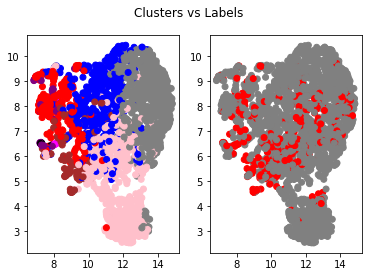

Training data


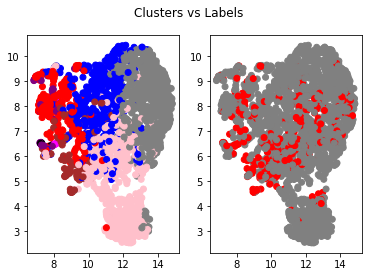


[ 0/50] train_loss: 5.623 valid_loss: 0.468 valid_F1: 0.006 valid_AUC: 0.568 valid_Feature_p: 0.458 valid_Silhouette: 0.104 val_ori_NMI: 0.757
Epoch: 00 | Loss: nan | Classification Loss: nan | Class Sep Loss: 12.148
Epoch: 01 | Loss: nan | Classification Loss: nan | Class Sep Loss: 8.190
Training data


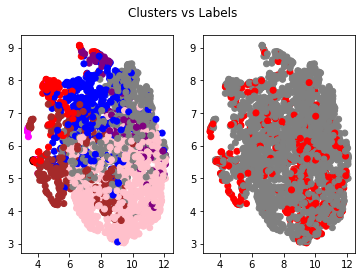


[ 2/50] train_loss: 4.059 valid_loss: 0.409 valid_F1: 0.000 valid_AUC: 0.637 valid_Feature_p: 0.430 valid_Silhouette: 0.089 val_ori_NMI: 0.287
Epoch: 02 | Loss: nan | Classification Loss: nan | Class Sep Loss: 6.128
Epoch: 03 | Loss: nan | Classification Loss: nan | Class Sep Loss: 6.332
Training data


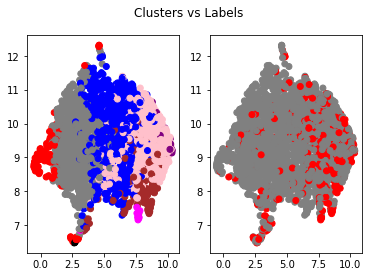


[ 4/50] train_loss: 4.078 valid_loss: 0.381 valid_F1: 0.000 valid_AUC: 0.710 valid_Feature_p: 0.419 valid_Silhouette: 0.084 val_ori_NMI: 0.126
Epoch: 04 | Loss: nan | Classification Loss: nan | Class Sep Loss: 4.787
Epoch: 05 | Loss: nan | Classification Loss: nan | Class Sep Loss: 3.667
Training data


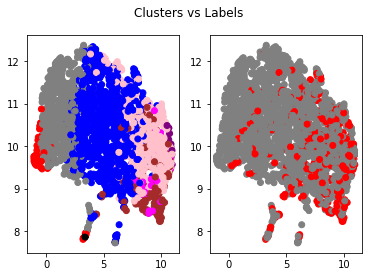


[ 6/50] train_loss: 4.004 valid_loss: 0.361 valid_F1: 0.000 valid_AUC: 0.761 valid_Feature_p: 0.390 valid_Silhouette: 0.113 val_ori_NMI: 0.081
Epoch: 06 | Loss: nan | Classification Loss: nan | Class Sep Loss: 4.791
Epoch: 07 | Loss: 942.060 | Classification Loss: 1.588 | Class Sep Loss: 2.825
Training data


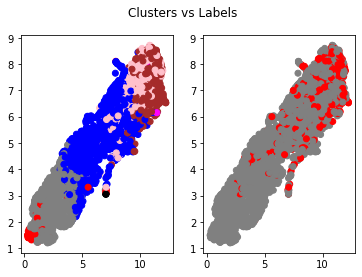


[ 8/50] train_loss: nan valid_loss: 0.340 valid_F1: 0.000 valid_AUC: 0.804 valid_Feature_p: 0.375 valid_Silhouette: 0.104 val_ori_NMI: 0.074
Epoch: 08 | Loss: 923.517 | Classification Loss: 1.099 | Class Sep Loss: 3.226
Epoch: 09 | Loss: 924.573 | Classification Loss: 1.220 | Class Sep Loss: 3.041
Training data


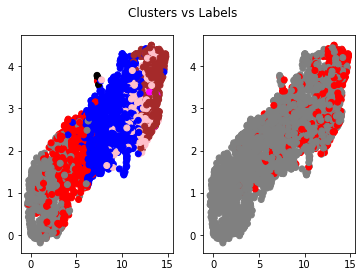


[10/50] train_loss: nan valid_loss: 0.321 valid_F1: 0.000 valid_AUC: 0.831 valid_Feature_p: 0.382 valid_Silhouette: 0.108 val_ori_NMI: 0.069
Epoch: 10 | Loss: 916.174 | Classification Loss: 0.833 | Class Sep Loss: 3.229
Epoch: 11 | Loss: 912.983 | Classification Loss: 0.897 | Class Sep Loss: 3.788
Training data


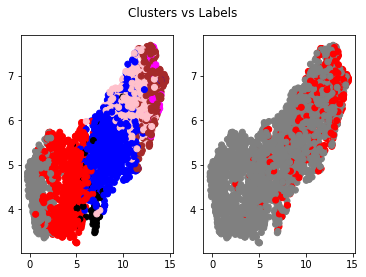


[12/50] train_loss: nan valid_loss: 0.311 valid_F1: 0.000 valid_AUC: 0.846 valid_Feature_p: 0.428 valid_Silhouette: 0.136 val_ori_NMI: 0.089
Epoch: 12 | Loss: 906.680 | Classification Loss: 0.750 | Class Sep Loss: 2.543
Epoch: 13 | Loss: 903.848 | Classification Loss: 0.706 | Class Sep Loss: 3.910
Training data


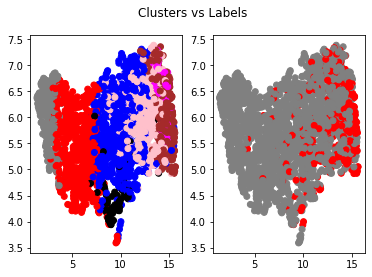


[14/50] train_loss: nan valid_loss: 0.299 valid_F1: 0.278 valid_AUC: 0.859 valid_Feature_p: 0.430 valid_Silhouette: 0.119 val_ori_NMI: 0.098
Epoch: 14 | Loss: 902.853 | Classification Loss: 1.034 | Class Sep Loss: 3.366
Epoch: 15 | Loss: 899.863 | Classification Loss: 0.539 | Class Sep Loss: 3.430
Training data


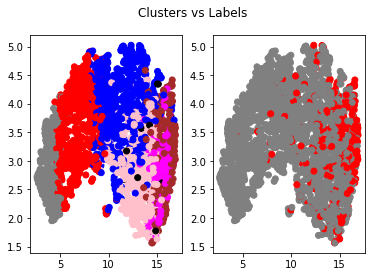


[16/50] train_loss: nan valid_loss: 0.298 valid_F1: 0.415 valid_AUC: 0.858 valid_Feature_p: 0.451 valid_Silhouette: 0.134 val_ori_NMI: 0.091
EarlyStopping counter: 1 out of 7
Epoch: 16 | Loss: 895.491 | Classification Loss: 0.337 | Class Sep Loss: 3.087
Epoch: 17 | Loss: 892.602 | Classification Loss: 0.298 | Class Sep Loss: 3.147
Training data


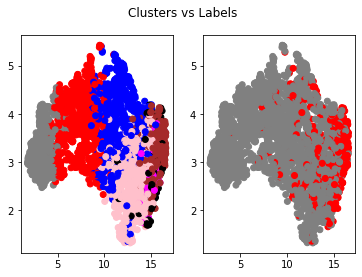


[18/50] train_loss: nan valid_loss: 0.303 valid_F1: 0.407 valid_AUC: 0.860 valid_Feature_p: 0.459 valid_Silhouette: 0.143 val_ori_NMI: 0.092
Epoch: 18 | Loss: 891.094 | Classification Loss: 0.430 | Class Sep Loss: 3.743
Epoch: 19 | Loss: 888.263 | Classification Loss: 0.308 | Class Sep Loss: 3.161
Training data


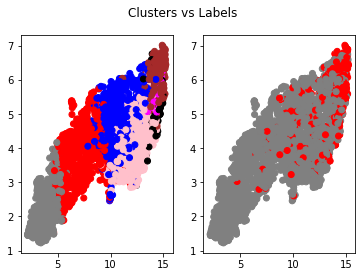


[20/50] train_loss: nan valid_loss: 0.311 valid_F1: 0.431 valid_AUC: 0.862 valid_Feature_p: 0.474 valid_Silhouette: 0.152 val_ori_NMI: 0.097
Epoch: 20 | Loss: 886.446 | Classification Loss: 0.262 | Class Sep Loss: 2.669
Epoch: 21 | Loss: 885.151 | Classification Loss: 0.334 | Class Sep Loss: 3.275
Training data


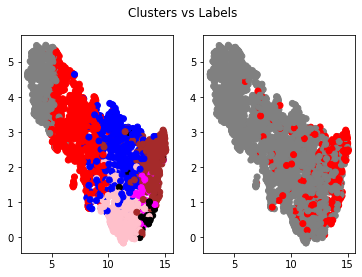


[22/50] train_loss: nan valid_loss: 0.330 valid_F1: 0.517 valid_AUC: 0.848 valid_Feature_p: 0.476 valid_Silhouette: 0.120 val_ori_NMI: 0.102
EarlyStopping counter: 1 out of 7
Epoch: 22 | Loss: 883.516 | Classification Loss: 0.325 | Class Sep Loss: 3.951
Epoch: 23 | Loss: 881.175 | Classification Loss: 0.222 | Class Sep Loss: 2.257
Training data


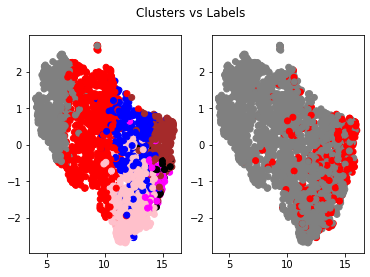


[24/50] train_loss: nan valid_loss: 0.373 valid_F1: 0.437 valid_AUC: 0.839 valid_Feature_p: 0.466 valid_Silhouette: 0.118 val_ori_NMI: 0.102
EarlyStopping counter: 2 out of 7
Epoch: 24 | Loss: 879.041 | Classification Loss: 0.279 | Class Sep Loss: 3.456
Epoch: 25 | Loss: 875.957 | Classification Loss: 0.213 | Class Sep Loss: 3.447
Training data


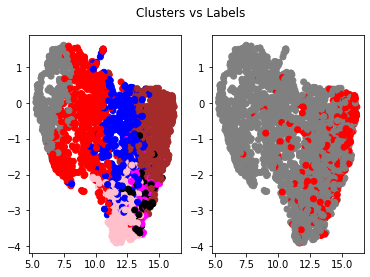


[26/50] train_loss: nan valid_loss: 0.532 valid_F1: 0.469 valid_AUC: 0.817 valid_Feature_p: 0.469 valid_Silhouette: 0.112 val_ori_NMI: 0.109
EarlyStopping counter: 3 out of 7
Epoch: 26 | Loss: 877.584 | Classification Loss: 0.218 | Class Sep Loss: 2.297
Epoch: 27 | Loss: 875.594 | Classification Loss: 0.143 | Class Sep Loss: 2.030
Training data


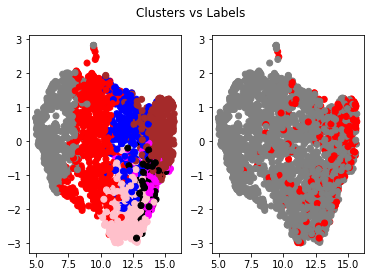


[28/50] train_loss: nan valid_loss: 0.441 valid_F1: 0.507 valid_AUC: 0.835 valid_Feature_p: 0.474 valid_Silhouette: 0.119 val_ori_NMI: 0.100
EarlyStopping counter: 4 out of 7
Epoch: 28 | Loss: 874.597 | Classification Loss: 0.215 | Class Sep Loss: 2.246
Epoch: 29 | Loss: 874.775 | Classification Loss: 0.096 | Class Sep Loss: 2.259
Training data


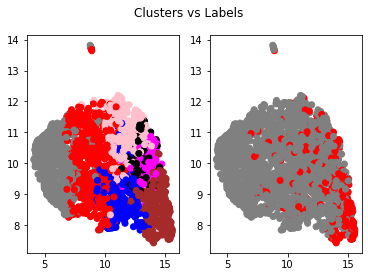


[30/50] train_loss: nan valid_loss: 0.469 valid_F1: 0.516 valid_AUC: 0.833 valid_Feature_p: 0.358 valid_Silhouette: 0.128 val_ori_NMI: 0.081
EarlyStopping counter: 5 out of 7
Epoch: 30 | Loss: 872.331 | Classification Loss: 0.090 | Class Sep Loss: 2.884
Epoch: 31 | Loss: 869.504 | Classification Loss: 0.057 | Class Sep Loss: 2.071
Training data


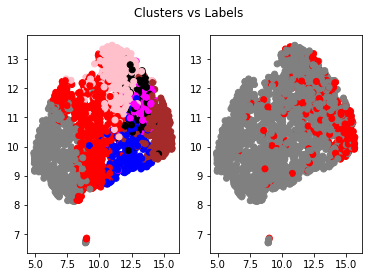


[32/50] train_loss: nan valid_loss: 0.508 valid_F1: 0.499 valid_AUC: 0.827 valid_Feature_p: 0.372 valid_Silhouette: 0.119 val_ori_NMI: 0.105
EarlyStopping counter: 6 out of 7
Epoch: 32 | Loss: 867.152 | Classification Loss: 0.034 | Class Sep Loss: 1.553
Epoch: 33 | Loss: 867.211 | Classification Loss: 0.062 | Class Sep Loss: 1.997
Training data


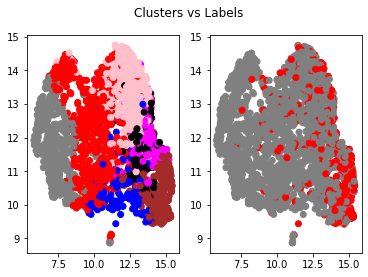


[34/50] train_loss: nan valid_loss: 0.602 valid_F1: 0.447 valid_AUC: 0.796 valid_Feature_p: 0.473 valid_Silhouette: 0.104 val_ori_NMI: 0.116
EarlyStopping counter: 7 out of 7
Training data


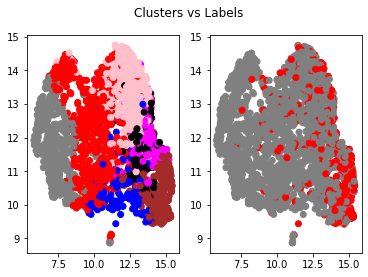

In [905]:
print("Starting Training")
model.train()
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

N_EPOCHS = args.n_epochs
es = EarlyStoppingCAC(dataset=suffix)
plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)

for epoch in range(N_EPOCHS):
    if epoch % args.log_interval == 0:
        model.ae.eval() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].eval()

#         print("Original labels")
#         plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=ori_val_cluster_indices)
#         print("New Labels")
        plot(model, torch.FloatTensor(X_val).to(args.device), y_val)

        X_latents, _, tmp_q = model(torch.Tensor(X_train).to(args.device), output="decoded")
        tmp_q, tmp_q_p, tmp_q_n = tmp_q
        # update target distribution p
        tmp_q = tmp_q.data

        # evaluate clustering performance
        cluster_indices = tmp_q.cpu().numpy().argmax(1)

        # Calculate Training Metrics
        nmi, acc, ari = 0, 0, 0
        train_loss = 0

        for j in range(args.n_clusters):
            # kmeans = KMeans(n_clusters=args.n_classes, n_init=20)
            cluster_idx = np.where(cluster_indices == j)[0]
            # y_pred_idx = kmeans.fit_predict(X_latents.data.cpu().numpy()[cluster_idx])
            # nmi_k = nmi_score(y_pred_idx, y[cluster_idx])
            # nmi += nmi_k * len(cluster_idx)/len(X_train)
            # acc += cluster_acc(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)
            # ari += ari_score(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)

            X_cluster = X_latents[cluster_idx]
            y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

            classifier_k, optimizer_k = model.classifiers[j]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            train_loss += cluster_los

        # Evaluate model on Test dataset
        qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
        q_val = qs[0]
        val_cluster_ids = torch.argmax(q_val, axis=1)
        val_cluster_ids = torch.Tensor(kmeans.fit_predict(z_val.data.cpu().numpy()))
        preds = torch.zeros((len(z_val), 2))

        # Weighted predictions
        if args.attention == False:
            for j in range(model.n_clusters):
                cluster_id = np.where(val_cluster_ids == j)[0]
                X_cluster = z_val[cluster_id]
                cluster_preds_val = model.classifiers[j][0](X_cluster)
                preds[cluster_id,:] = cluster_preds_val

        else:
            for j in range(model.n_clusters):
                cluster_id = np.where(val_cluster_ids == j)[0]
                X_cluster = z_val
                cluster_preds = model.classifiers[j][0](X_cluster)
                preds[:,0] += q_val[:,j]*cluster_preds[:,0]
                preds[:,1] += q_val[:,j]*cluster_preds[:,1]

        feature_diff = 0
        cntr = 0
        for i in range(args.n_clusters):
            for j in range(args.n_clusters):
                if i > j:
                    ci = torch.where(val_cluster_ids == i)[0]
                    cj = torch.where(val_cluster_ids == j)[0]
                    Xi = X_val[ci]
                    Xj = X_val[cj]
                    feature_diff += sum(ttest_ind(Xi, Xj, axis=0)[1] < 0.05)/args.input_dim
                    # print("Cluster [{}, {}] p-value: ".format(i,j), feature_diff)
                    cntr += 1

        val_sil = silhouette_score(z_val.data.cpu().numpy(), val_cluster_ids.data.cpu().numpy(), metric='euclidean')
        # val_sil = 0
        val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
        val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
        val_feature_diff = feature_diff/cntr

        loss = criterion(preds, torch.Tensor(y_val).type(torch.LongTensor))
        # record validation loss
        valid_losses.append(loss.item())

        # calculate average loss over an epoch
        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)
        val_ori_nmi = nmi_score(ori_val_cluster_indices, val_cluster_ids.data.cpu().numpy())

        epoch_len = len(str(N_EPOCHS))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'valid_loss: {valid_loss:.3f} '  +
                     f'valid_F1: {val_f1:.3f} '  +
                     f'valid_AUC: {val_auc:.3f} ' + 
                     f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                     f'valid_Silhouette: {val_sil:.3f} ' +
                     f'val_ori_NMI: {val_ori_nmi:.3f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        es([val_f1, val_auc], model)
        if es.early_stop == True:
            break

    # Normal Training
    epoch_loss = 0
    epoch_sep_loss = 0

    model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
        # torch.autograd.set_detect_anomaly(True)
        x_batch = x_batch.to(device)
        idx = idx.to(device)

        X_latents, x_bar, qs = model(x_batch)
        q, q_p, q_n = qs
        reconstr_loss = F.mse_loss(x_bar, x_batch)

        classifier_labels = np.zeros(len(idx))
        train_epochs = min(10, 1 + int(epoch/5))
        if args.attention == False:
            classifier_labels = np.argmax(q.detach().cpu().numpy(), axis=1)

        for _ in range(train_epochs):
            # Choose classifier for a point probabilistically
            if args.attention == True:
                for j in range(len(idx)):
                    classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q[j].detach().numpy())

            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = criterion(y_pred_cluster, y_cluster)
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()

        class_loss = torch.tensor(0.).to(args.device)
        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            class_loss += cluster_los

        delta_mu_p = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu_n = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        cluster_id = torch.argmax(q, 1)

        positive_class_dist = 0
        negative_class_dist = 0
        km_loss             = 0
        class_sep_loss = 0

        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            cluster_pts = X_latents[pts_index]
            n_class_index = np.where(y_batch[pts_index] == 0)[0]
            p_class_index = np.where(y_batch[pts_index] == 1)[0]

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            delta_mu_p[j,:] = p_class.sum(axis=0)/(1+len(p_class))
            delta_mu_n[j,:] = n_class.sum(axis=0)/(1+len(n_class))
            delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))

            s1 = torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/(1+len(p_class))
            s2 = torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/(1+len(n_class))
            m12 = torch.linalg.vector_norm(model.p_cluster_layer[j] - model.n_cluster_layer[j])

            class_sep_loss += (s1+s2)/m12
            km_loss += torch.linalg.vector_norm(X_latents[pts_index] - model.cluster_layer[j])/(1+len(cluster_pts))
        
        q_tmp = source_distribution(X_latents, model.cluster_layer)
        km_loss -= torch.sum(torch.kl_div(torch.sum(q_tmp, axis=0), torch.ones(args.n_clusters)))/args.n_clusters
        loss = reconstr_loss
        if args.beta != 0:
            loss += args.beta*km_loss
        if args.gamma != 0:
            loss += args.gamma*class_loss
        if args.delta != 0:
            loss += args.delta*class_sep_loss

        epoch_loss += loss
        epoch_sep_loss += class_sep_loss.item()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # Update the positive and negative centroids
        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            N  = len(pts_index)
            Np = len(p_class_index)
            Nn = len(n_class_index)
            model.p_cluster_layer.data[j:] -= (1/(100+Np))*delta_mu_p[j:]
            model.n_cluster_layer.data[j:] -= (1/(100+Nn))*delta_mu_n[j:]
            model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

    print('Epoch: {:02d} | Loss: {:.3f} | Classification Loss: {:.3f} | Class Sep Loss: {:.3f}'.format(
                epoch, epoch_loss, class_loss/train_epochs, class_sep_loss))

plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)

In [906]:
q = source_distribution(z_val, model.cluster_layer)
print(sum(torch.kl_div(torch.sum(q,axis=0), torch.ones(model.n_clusters)/model.n_clusters)))
print(np.bincount(q.argmax(1)))

tensor(-283.3294, grad_fn=<AddBackward0>)
[481 637 159 484 233 113 143]


## Local Training


####################################################################################

Training Local Networks
Loading Best model with score:  [0.43064182194616973, 0.8616759240759241]  named:  ./pretrained_model/checkpoint_cic_8_True.pt
Training data


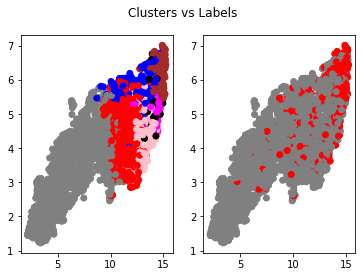


[34/50] train_loss: nan valid_loss: 0.304 valid_F1: 0.438 valid_AUC: 0.861

[34/50] train_loss: nan valid_loss: 0.301 valid_F1: 0.476 valid_AUC: 0.861
EarlyStopping counter: 1 out of 7

[34/50] train_loss: nan valid_loss: 0.302 valid_F1: 0.485 valid_AUC: 0.860
EarlyStopping counter: 2 out of 7

[34/50] train_loss: nan valid_loss: 0.303 valid_F1: 0.493 valid_AUC: 0.860
EarlyStopping counter: 3 out of 7

[34/50] train_loss: nan valid_loss: 0.304 valid_F1: 0.493 valid_AUC: 0.860
EarlyStopping counter: 4 out of 7

[34/50] train_loss: nan valid_loss: 0.306 valid_F1: 0.488 valid_AUC: 0.860
EarlyStopping counter: 5 out of 7

[34/50] train_loss: nan valid_loss: 0.307 valid_F1: 0.485 valid_AUC: 0.860
EarlyStopping counter: 6 out of 7

[34/50] train_loss: nan valid_loss: 0.308 valid_F1: 0.486 valid_AUC: 0.859
EarlyStopping counter: 7 out of 7


In [907]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

model.ae.eval() # prep model for evaluation
for j in range(model.n_clusters):
    model.classifiers[j][0].eval()

# qs, latents_X = model(torch.FloatTensor(np.array(X_val)).to(args.device), output="latent")
# qs = source_distribution(latents_X, model.cluster_layer)
# print(np.bincount(qs.argmax(1)))
plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)
es = EarlyStoppingCAC(dataset=suffix)

qs, latents_X = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
X_latents_data_loader = list(zip(latents_X.to(args.device),q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

# Post clustering training
for e in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        if args.attention == True:
            for j in range(len(X_latents)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
        else:
            classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()
        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = criterion(y_pred_cluster, y_cluster)
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()
    
    model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    # Evaluate model on Validation set
    qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
    q_val = qs[0]
    cluster_ids = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_val
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_val[:,j]*cluster_preds[:,0]
        preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
    val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())

    loss = criterion(preds, torch.Tensor(y_val).type(torch.LongTensor))
    # record validation loss
    valid_losses.append(loss.item())

    # calculate average loss over an epoch
    valid_loss = np.average(valid_losses)
    avg_valid_losses.append(valid_loss)
    
    epoch_len = len(str(N_EPOCHS))
    
    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'valid_loss: {valid_loss:.3f} '  +
                 f'valid_F1: {val_f1:.3f} '  +
                 f'valid_AUC: {val_auc:.3f}')
    
    print(print_msg)
    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([val_f1, val_auc], model)
    if es.early_stop == True:
        break

## Evaluating on Test Data

In [908]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)

# # Evaluate model on Test dataset
qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
q_test = qs[0]
cluster_ids = torch.argmax(q_test, axis=1)
preds_e = torch.zeros((len(z_test), 2))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_test
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_test[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_test[:,j]*cluster_preds[:,1]

e_test_f1 = f1_score(y_test, np.argmax(preds_e.detach().numpy(), axis=1))
e_test_auc = roc_auc_score(y_test, preds_e[:,1].detach().numpy())
e_test_acc = accuracy_score(y_test, np.argmax(preds_e.detach().numpy(), axis=1))
e_test_loss = criterion(preds_e, torch.Tensor(y_test).type(torch.LongTensor))

preds = torch.zeros((len(z_test), 2))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    cluster_preds = model.classifiers[j][0](X_cluster)
    preds[cluster_id,:] = cluster_preds

test_f1 = f1_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
test_auc = roc_auc_score(y_test, preds[:,1].detach().numpy())
test_acc = accuracy_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
test_loss = criterion(preds, torch.Tensor(y_test).type(torch.LongTensor))

print('Acc {:.4f}'.format(acc),
      ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari),\
      ', Test Loss {:.3f}, E-Test Loss {:.3f}'.format(test_loss, e_test_loss))

print('Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, np.argmax(preds_e.detach().numpy(), axis=1)).ravel()
se = tp/(tp+fn)
pn = tp/(tp+fp)
print(se, pn)
print("score1: ", min(se, pn))


####################################################################################

Evaluating Test Data with k =  8  Attention =  True
Loading Best model with score:  [0.43824701195219123, 0.8610541458541457]  named:  ./pretrained_model/checkpoint_cic_8_True.pt
Acc 0.0000 , nmi 0.0000 , ari 0.0000 , Test Loss 0.326, E-Test Loss 0.324
Test F1 0.432, Test AUC 0.836, Test ACC 0.868 , E-Test F1 0.429, E-Test AUC 0.848, E-Test ACC 0.872
0.3364485981308411 0.5901639344262295
score1:  0.3364485981308411


In [909]:
print(z_val, q_val)
q_labels = torch.argmax(q_val, axis=1).data.cpu().numpy()
km_labels = kmeans.fit_predict(z_val.data.cpu().numpy())
print(km_labels)
print(nmi_score(q_labels, km_labels))

tensor([[-0.0559,  0.8993, -0.2890,  ..., -0.2272,  0.2019, -0.1116],
        [-0.2071,  0.7157, -0.1065,  ...,  0.0117,  0.1134, -0.0133],
        [-0.1826, -0.0977, -0.0751,  ..., -0.0841,  0.2563, -0.2966],
        ...,
        [-0.1167,  0.7081,  0.0396,  ..., -0.1614,  0.1188, -0.1388],
        [ 0.0277,  0.1141,  0.1011,  ..., -0.1245,  0.1147, -0.0641],
        [ 0.0328, -0.0530, -0.1617,  ...,  0.0123, -0.0848, -0.0384]],
       grad_fn=<AddmmBackward>) tensor([[0.2226, 0.1414, 0.1240,  ..., 0.1117, 0.1117, 0.0648],
        [0.2186, 0.1456, 0.1249,  ..., 0.1144, 0.1141, 0.0536],
        [0.1073, 0.1371, 0.1465,  ..., 0.1420, 0.1423, 0.0425],
        ...,
        [0.2230, 0.1464, 0.1240,  ..., 0.1130, 0.1127, 0.0542],
        [0.1223, 0.1460, 0.1484,  ..., 0.1369, 0.1361, 0.0394],
        [0.1026, 0.1386, 0.1380,  ..., 0.1448, 0.1453, 0.0429]],
       grad_fn=<TBackward>)
[1 4 0 ... 3 0 0]
0.3843426074560817


In [910]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_test[cluster_id]
    if args.attention == True:
        y_cluster = preds_e[cluster_id][:,1]
    else:
        y_cluster = preds[cluster_id][:,1]
#     if len(cluster_id) > 0:
    print(y_cluster.shape)
    regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
    best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
    print("Cluster #", j)
    print(column_names[best_features])
    print("=========================\n")

torch.Size([1614])
Cluster # 0
Index(['CSRU', 'Age', 'GCS_first', 'MechVentLast8Hour', 'BUN_last', 'GCS_last',
       'GCS_median', 'HR_last', 'RespRate_first', 'Weight_first'],
      dtype='object')

torch.Size([536])
Cluster # 1
Index(['Age', 'MAP_lowest', 'TroponinT_first', 'Glucose_median', 'MAP_last',
       'Glucose_last', 'GCS_first', 'Platelets_first', 'Length_of_stay',
       'pH_last'],
      dtype='object')

torch.Size([203])
Cluster # 2
Index(['Creatinine_first', 'NIDiasABP_median', 'TroponinI_last', 'FiO2_last',
       'Temp_median', 'HR_median', 'Lactate_last', 'Glucose_median',
       'MAP_last', 'NIMAP_last'],
      dtype='object')

torch.Size([286])
Cluster # 3
Index(['Age', 'Length_of_stay', 'Glucose_last', 'HCT_first', 'NISysABP_median',
       'Mg_first', 'Glucose_median', 'SaO2_first', 'NIDiasABP_highest',
       'Lactate_first'],
      dtype='object')

torch.Size([191])
Cluster # 4
Index(['Lactate_last', 'Length_of_stay', 'ALP_last', 'WBC_last',
       'Glucose_la

ValueError: Found array with 0 sample(s) (shape=(0, 117)) while a minimum of 1 is required.

## Baseline Model

In [626]:
f1_scores, auc_scores = [], []

for r in range(5):
    m = NNClassifier(args, input_dim=89)
    device = args.device

    N_EPOCHS = args.n_epochs
    es = EarlyStopping(dataset=args.dataset, path="./pretrained_model/checkpoint_base")

    kmeans = KMeans(n_clusters=args.n_classes, n_init=20)

    for e in range(1, N_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        m.train()
        nmi, acc, ari = 0, 0, 0

#         for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = torch.FloatTensor(X_train), torch.Tensor(y_train).type(torch.LongTensor)
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score(np.argmax(y_pred, axis=1), y_batch)
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()


        m.classifier.eval()
        val_pred = m(torch.FloatTensor(X_val).to(args.device))
        val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, torch.Tensor(y_val).type(torch.LongTensor))

        val_f1 = f1_score(torch.argmax(val_pred, axis=1), y_val)
        val_auc = roc_auc_score(y_val, val_pred[:,1].data.cpu().numpy())
        es([val_f1, val_auc], m)

        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
            f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
            f'Val F1: {val_f1:.3f} | Val Acc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

        if es.early_stop == True:
            break


    ###################################### Testing #####################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data")

    # Load best model trained from local training phase
    m = es.load_checkpoint(m)
    m.classifier.eval()
    test_pred = m.classifier(torch.FloatTensor(X_test))
    test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.Tensor(y_test).type(torch.LongTensor))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
    test_auc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())
    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    
    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
        f'Test F1: {test_f1:.3f} | Test Acc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')


#     reg = GradientBoostingRegressor(random_state=0)

#     reg.fit(X_test, y_test)
#     best_features = np.argsort(reg.feature_importances_)[::-1][:10]
#     print("Best Features ")
#     print(column_names[best_features])
#     print("=========================\n")
print(f1_scores, auc_scores)
print("Avg. Test F1 = {:.3f}, AUC = {:.3f}".format(np.average(f1_scores), np.average(auc_scores)))

Epoch 001: | Train Loss: 0.01984 |  Train F1: 0.000 | Train Acc: 0.018|  Val F1: 0.000 | Val Acc: 0.559 | Val Loss: 0.564
Epoch 002: | Train Loss: 0.01951 |  Train F1: 0.000 | Train Acc: 0.019|  Val F1: 0.000 | Val Acc: 0.588 | Val Loss: 0.554
Epoch 003: | Train Loss: 0.01918 |  Train F1: 0.000 | Train Acc: 0.020|  Val F1: 0.000 | Val Acc: 0.602 | Val Loss: 0.544
Epoch 004: | Train Loss: 0.01884 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.612 | Val Loss: 0.534
Epoch 005: | Train Loss: 0.01849 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.614 | Val Loss: 0.524
EarlyStopping counter: 1 out of 7
Epoch 006: | Train Loss: 0.01813 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.612 | Val Loss: 0.512
EarlyStopping counter: 2 out of 7
Epoch 007: | Train Loss: 0.01776 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.609 | Val Loss: 0.500
EarlyStopping counter: 3 out of 7
Epoch 008: | Train Loss: 0.01735 |  Train F1

Epoch 044: | Train Loss: 0.00942 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.606 | Val Loss: 0.259
Epoch 045: | Train Loss: 0.00941 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.608 | Val Loss: 0.259
Epoch 046: | Train Loss: 0.00940 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.609 | Val Loss: 0.258
Epoch 047: | Train Loss: 0.00938 |  Train F1: 0.000 | Train Acc: 0.021|  Val F1: 0.000 | Val Acc: 0.610 | Val Loss: 0.258
Epoch 048: | Train Loss: 0.00936 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.612 | Val Loss: 0.257
Epoch 049: | Train Loss: 0.00934 |  Train F1: 0.000 | Train Acc: 0.022|  Val F1: 0.000 | Val Acc: 0.614 | Val Loss: 0.257

####################################################################################

Evaluating Test Data
Loading Best model with score:  [0.0, 0.6135114589475008]
Epoch 049: | Train Loss: 0.00934 |  Train F1: 0.000 | Train Acc: 0.022|  Test F1: 0.000 | Test Acc: 0.

# OLD CODE

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/creditcard.pth
Load pretrained AE from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/creditcard.pth
NMI score=0.0144
Starting Training
Training data


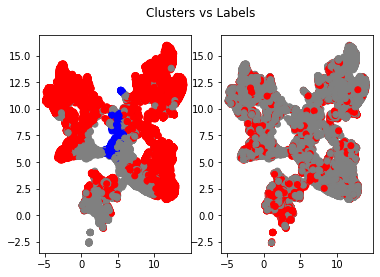

0.3528356870656803 0.5718300570057607
0.3174642635177129 0.5627465390552949
Iter 0 : Acc 0.5541 , nmi 0.0144 , ari -0.0031 , Test F1 0.317, Test AUC 0.563
Epoch: 00 | Loss: 86.883 | Classification Loss: 1.403 | Class Sep Loss: 1.829
Epoch: 01 | Loss: 67.760 | Classification Loss: 1.397 | Class Sep Loss: 0.908
Epoch: 02 | Loss: 64.346 | Classification Loss: 1.431 | Class Sep Loss: 0.796
Epoch: 03 | Loss: 63.044 | Classification Loss: 1.424 | Class Sep Loss: 0.867
Epoch: 04 | Loss: 63.025 | Classification Loss: 1.219 | Class Sep Loss: 1.132
Epoch: 05 | Loss: 64.007 | Classification Loss: 0.603 | Class Sep Loss: 1.053
Epoch: 06 | Loss: 63.102 | Classification Loss: 0.726 | Class Sep Loss: 0.510
Epoch: 07 | Loss: 62.925 | Classification Loss: 0.597 | Class Sep Loss: 1.149
Epoch: 08 | Loss: 62.424 | Classification Loss: 0.674 | Class Sep Loss: 1.119
Epoch: 09 | Loss: 61.893 | Classification Loss: 0.702 | Class Sep Loss: 1.077
Training data


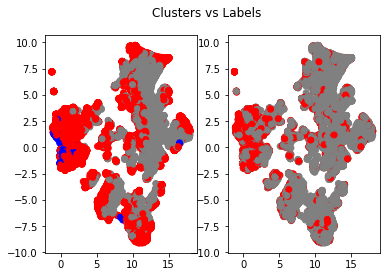

0.48611111111111116 0.7842938332030154
0.4962406015037594 0.7801297144198511
Iter 10 : Acc 0.6070 , nmi 0.0846 , ari 0.0759 , Test F1 0.496, Test AUC 0.780
Epoch: 10 | Loss: 61.731 | Classification Loss: 0.442 | Class Sep Loss: 1.003
Epoch: 11 | Loss: 61.393 | Classification Loss: 0.434 | Class Sep Loss: 1.032
Epoch: 12 | Loss: 60.926 | Classification Loss: 0.450 | Class Sep Loss: 1.088
Epoch: 13 | Loss: 60.560 | Classification Loss: 0.452 | Class Sep Loss: 0.947
Epoch: 14 | Loss: 60.176 | Classification Loss: 0.426 | Class Sep Loss: 1.028
Epoch: 15 | Loss: 60.249 | Classification Loss: 0.313 | Class Sep Loss: 0.965
Epoch: 16 | Loss: 60.062 | Classification Loss: 0.332 | Class Sep Loss: 0.884
Epoch: 17 | Loss: 59.510 | Classification Loss: 0.334 | Class Sep Loss: 0.891
Epoch: 18 | Loss: 59.336 | Classification Loss: 0.321 | Class Sep Loss: 0.934
Epoch: 19 | Loss: 59.365 | Classification Loss: 0.330 | Class Sep Loss: 0.801
Training data


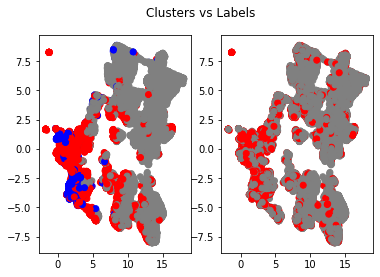

0.5060407317915084 0.7765177240800887
0.5109739368998628 0.7716670864409159
Iter 20 : Acc 0.6846 , nmi 0.1078 , ari 0.1292 , Test F1 0.511, Test AUC 0.772
Epoch: 20 | Loss: 58.769 | Classification Loss: 0.245 | Class Sep Loss: 0.881
Epoch: 21 | Loss: 58.760 | Classification Loss: 0.238 | Class Sep Loss: 0.870
Epoch: 22 | Loss: 58.578 | Classification Loss: 0.245 | Class Sep Loss: 0.912
Epoch: 23 | Loss: 58.217 | Classification Loss: 0.267 | Class Sep Loss: 0.836
Epoch: 24 | Loss: 58.096 | Classification Loss: 0.260 | Class Sep Loss: 0.844
Epoch: 25 | Loss: 57.937 | Classification Loss: 0.223 | Class Sep Loss: 0.820
Epoch: 26 | Loss: 57.606 | Classification Loss: 0.173 | Class Sep Loss: 0.790
Epoch: 27 | Loss: 57.726 | Classification Loss: 0.209 | Class Sep Loss: 0.688
Epoch: 28 | Loss: 57.459 | Classification Loss: 0.193 | Class Sep Loss: 0.696
Epoch: 29 | Loss: 57.042 | Classification Loss: 0.237 | Class Sep Loss: 0.729
Training data


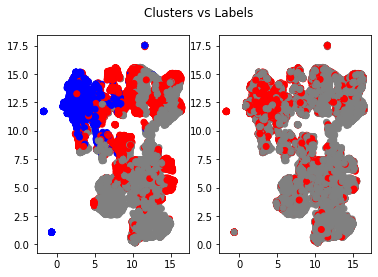

0.49387897866386854 0.7753152588148414
0.4889045438534695 0.7677920062452384
Iter 30 : Acc 0.6575 , nmi 0.1125 , ari 0.1136 , Test F1 0.489, Test AUC 0.768
Epoch: 30 | Loss: 56.764 | Classification Loss: 0.176 | Class Sep Loss: 0.676
Epoch: 31 | Loss: 56.785 | Classification Loss: 0.182 | Class Sep Loss: 0.681
Epoch: 32 | Loss: 56.432 | Classification Loss: 0.177 | Class Sep Loss: 0.663
Epoch: 33 | Loss: 56.374 | Classification Loss: 0.178 | Class Sep Loss: 0.708
Epoch: 34 | Loss: 56.477 | Classification Loss: 0.172 | Class Sep Loss: 0.701
Epoch: 35 | Loss: 55.956 | Classification Loss: 0.162 | Class Sep Loss: 0.651
Epoch: 36 | Loss: 55.522 | Classification Loss: 0.134 | Class Sep Loss: 0.655
Epoch: 37 | Loss: 55.163 | Classification Loss: 0.154 | Class Sep Loss: 0.647
Epoch: 38 | Loss: 55.218 | Classification Loss: 0.148 | Class Sep Loss: 0.658
Epoch: 39 | Loss: 54.763 | Classification Loss: 0.145 | Class Sep Loss: 0.656
Training data


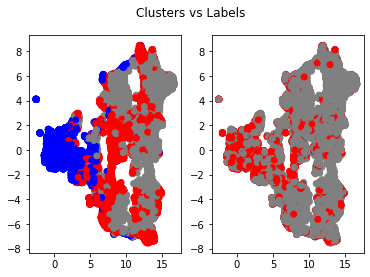

0.4161896974652494 0.7640339302899074
0.4108463434675432 0.7594359925718753
Iter 40 : Acc 0.6542 , nmi 0.1232 , ari 0.1100 , Test F1 0.411, Test AUC 0.759
Epoch: 40 | Loss: 55.021 | Classification Loss: 0.136 | Class Sep Loss: 0.690
Epoch: 41 | Loss: 54.765 | Classification Loss: 0.130 | Class Sep Loss: 0.654
Epoch: 42 | Loss: 54.515 | Classification Loss: 0.126 | Class Sep Loss: 0.686
Epoch: 43 | Loss: 53.969 | Classification Loss: 0.132 | Class Sep Loss: 0.644
Epoch: 44 | Loss: 54.259 | Classification Loss: 0.122 | Class Sep Loss: 0.645
Epoch: 45 | Loss: 53.637 | Classification Loss: 0.117 | Class Sep Loss: 0.647
Epoch: 46 | Loss: 53.927 | Classification Loss: 0.116 | Class Sep Loss: 0.640
Epoch: 47 | Loss: 53.604 | Classification Loss: 0.120 | Class Sep Loss: 0.665
Epoch: 48 | Loss: 53.263 | Classification Loss: 0.120 | Class Sep Loss: 0.646
Epoch: 49 | Loss: 53.202 | Classification Loss: 0.110 | Class Sep Loss: 0.701


In [61]:

model = MultiHeadIDEC(
        n_enc_1=128,
        n_enc_2=64,
        n_enc_3=32,
        n_dec_1=32,
        n_dec_2=64,
        n_dec_3=128,
        args=args).to(args.device)

model.pretrain(train_loader, args.pretrain_path)

optimizer = Adam(model.parameters(), lr=args.lr)

# cluster parameter initiate
device = args.device
y = y_train
x_bar, hidden = model.ae(torch.Tensor(X_train).to(args.device))

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
cluster_indices = kmeans.labels_

nmi = 0
for j in range(args.n_clusters):
    kmeans = KMeans(n_clusters=args.n_classes, n_init=20)
    cluster_idx = np.where(cluster_indices == j)[0]
    y_pred_idx = kmeans.fit_predict(hidden.data.cpu().numpy()[cluster_idx])
    nmi_k = nmi_score(y_pred_idx, y[cluster_idx])
    nmi += len(cluster_idx)*nmi_k

print("NMI score={:.4f}".format(nmi/len(X_train)))

y_pred_last = y_pred

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
cluster_indices = kmeans.labels_

model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)
for i in range(args.n_clusters):
    cluster_idx = np.where(cluster_indices == i)[0]
    cluster_idx_p = np.where(y[cluster_idx] == 1)[0]
    cluster_idx_n = np.where(y[cluster_idx] == 0)[0]
    hidden_p = hidden[cluster_idx][cluster_idx_p]
    hidden_n = hidden[cluster_idx][cluster_idx_n]
    
    model.p_cluster_layer.data[i,:] = torch.mean(hidden_p, axis=0)
    model.n_cluster_layer.data[i,:] = torch.mean(hidden_n, axis=0)

criterion = nn.CrossEntropyLoss(reduction='mean')


####################################################################################
####################################################################################
####################################################################################
################################## Clustering Step #################################
####################################################################################
####################################################################################
####################################################################################


print("Starting Training")
model.train()
for epoch in range(50):
    if epoch % args.log_interval == 0:
        plot(model, torch.FloatTensor(X_train).to(args.device), y_train)
        X_latents, _, tmp_q = model(torch.Tensor(X_train).to(args.device), output="decoded")
        tmp_q, tmp_q_p, tmp_q_n = tmp_q
        # update target distribution p
        tmp_q = tmp_q.data

        p = target_distribution(tmp_q)
        p_p = target_distribution(tmp_q_p)
        p_n = target_distribution(tmp_q_n)

        # evaluate clustering performance
        y_pred = tmp_q.cpu().numpy().argmax(1)
        delta_label = np.sum(y_pred != y_pred_last).astype(
            np.float32) / y_pred.shape[0]
        y_pred_last = y_pred

        acc = cluster_acc(y, y_pred)
        # nmi = nmi_score(y, y_pred)

        nmi = 0
        acc = 0
        ari = 0
        for j in range(args.n_clusters):
            kmeans = KMeans(n_clusters=args.n_classes, n_init=20)
            cluster_idx = np.where(cluster_indices == j)[0]
            y_pred_idx = kmeans.fit_predict(X_latents.data.cpu().numpy()[cluster_idx])
            nmi_k = nmi_score(y_pred_idx, y[cluster_idx])
            nmi += nmi_k * len(cluster_idx)/len(X_train)
            acc += cluster_acc(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)
            ari += ari_score(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)

        # ari = ari_score(y, y_pred)
        qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
        q_test = qs[0]
        cluster_ids = torch.argmax(q_test, axis=1)
        preds = torch.zeros((len(z_test), 2))

        # Weighted predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids == j)[0]
            # X_cluster = z_test[cluster_id]
            X_cluster = z_test
            cluster_preds = model.classifiers[j][0](X_cluster)
            preds[:,0] += q_test[:,j]*cluster_preds[:,0]
            preds[:,1] += q_test[:,j]*cluster_preds[:,1]

        test_f1 = f1_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
        test_auc = roc_auc_score(y_test, preds[:,1].detach().numpy())
        print(test_f1, test_auc)
        # Hard local predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids == j)[0]
            X_cluster = z_test[cluster_id]
            cluster_preds = model.classifiers[j][0](X_cluster)
            preds[cluster_id,:] = cluster_preds

        test_f1 = f1_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
        test_auc = roc_auc_score(y_test, preds[:,1].detach().numpy())
        print(test_f1, test_auc)
        
        print('Iter {}'.format(epoch), ': Acc {:.4f}'.format(acc),
              ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari), 
              ', Test F1 {:.3f}, Test AUC {:.3f}'.format(test_f1, test_auc))

        if epoch > 0 and delta_label < args.tol:
            print('delta_label {:.4f}'.format(delta_label), '< tol',
                  args.tol)
            print('Reached tolerance threshold. Stopping training.')
            break

    epoch_loss = 0
    epoch_sep_loss = 0
    for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
        # torch.autograd.set_detect_anomaly(True)
        x_batch = x_batch.to(device)
        idx = idx.to(device)

        X_latents, x_bar, qs = model(x_batch)

#         print(batch_idx, qs, model.cluster_layer)

        q, q_p, q_n = qs
        reconstr_loss = F.mse_loss(x_bar, x_batch)
        kl_loss = F.kl_div(q.log(), p[idx], reduction="batchmean")
        
        classifier_labels = np.zeros(len(idx))
        train_epochs = min(10, 1 + int(epoch/5))
        for _ in range(train_epochs):
        # Choose classifier for a point probabilistically
            for j in range(len(idx)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q[j].detach().numpy())

            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = criterion(y_pred_cluster, y_cluster)
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()

        class_loss = torch.tensor(0.).to(args.device)
        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            class_loss += cluster_los

        N1 = sum(y_batch).item()
        N0 = len(y_batch) - N1

        p_idx = torch.where(y_batch == 1)[0]
        n_idx = torch.where(y_batch == 0)[0]
        
        delta_mu_p = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu_n = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        cluster_id = torch.argmax(q, 1)
        
        positive_class_dist = 0
        negative_class_dist = 0
        km_loss             = 0
        class_sep_loss = 0

        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            cluster_pts = X_latents[pts_index]
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            delta_mu_p[j,:] = p_class.sum(axis=0)/(1+len(p_class))
            delta_mu_n[j,:] = n_class.sum(axis=0)/(1+len(n_class))
            delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))

            s1 = torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/(1+len(p_class))
            s2 = torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/(1+len(n_class))
            m12 = torch.linalg.vector_norm(model.p_cluster_layer[j] - model.n_cluster_layer[j])
            class_sep_loss += (s1+s2)/m12
            # positive_class_dist += torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/len(p_class)
            # negative_class_dist += torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/len(n_class)
            km_loss += torch.linalg.vector_norm(X_latents[pts_index] - model.cluster_layer[j])/len(cluster_pts)

        loss = reconstr_loss
        if args.beta != 0:
            loss += args.beta*km_loss
        if args.gamma != 0:
            loss += args.gamma*class_loss
        if args.delta != 0:
            loss += args.delta*class_sep_loss

        epoch_loss += loss
        epoch_sep_loss += class_sep_loss.item()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # Update the positive and negative centroids
        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            N  = len(pts_index)
            Np = len(p_class_index)
            Nn = len(n_class_index)
            model.p_cluster_layer.data[j:] -= (1/(100+Np))*delta_mu_p[j:]
            model.n_cluster_layer.data[j:] -= (1/(100+Nn))*delta_mu_n[j:]
            model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

    print('Epoch: {:02d} | Loss: {:.3f} | Classification Loss: {:.3f} | Class Sep Loss: {:.3f}'.format(
                epoch, epoch_loss, class_loss/train_epochs, class_sep_loss))


# Batch wise hard cluster local networks

In [17]:
# Training separate models
args.lr = 0.002
classifiers = [NNClassifier(args, model.ae) for _ in range(args.n_clusters)]
# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 500
device = 'cpu'
model.eval()


qs, latents_X = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
X_latents_data_loader = list(zip(torch.FloatTensor(np.array(X_train)).to(args.device),\
                                 cluster_id_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

qs, latents_test = model(torch.FloatTensor(np.array(X_test)).to(args.device), output="latent")
q_test = qs[0]
cluster_id_test = torch.argmax(q_test, axis=1)
# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    alpha = (1-e/EPOCHS)
    acc = 0

    new_y = []
    y_pred = []
    for X_batch, cluster_batch, y_batch in train_loader_latents:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        new_y_batch = []
        y_pred = []
        for k in range(args.n_clusters):
            idx = np.where(cluster_batch == k)[0]
            y_pred_idx, loss = classifiers[k].fit(X_batch[idx], y_batch[idx])
#             print("F1 Cluster: ", k, f1_score(np.argmax(y_pred_idx, axis=1), y_batch[idx]))
#             print("Cluster: ", k, len(idx))
            new_y_batch.append(y_batch[idx])
            y_pred.append(y_pred_idx)
            epoch_loss += loss

        y_pred = np.vstack(y_pred)
        new_y_batch = np.hstack(new_y_batch)
#         print(y_pred.shape, new_y_batch, len(X_batch))
        f1 = f1_score(np.argmax(y_pred, axis=1), new_y_batch)
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    X_test = torch.FloatTensor(np.array(X_test)).to(args.device)
    for k in range(args.n_clusters):
        classifiers[k].classifier.eval()
        idx = np.where(cluster_id_test == k)[0]
#         latents_idx = latents_test[idx]
        X_test_idx = X_test[idx]
        y_pred_idx = classifiers[k](X_test_idx)
#         y_pred_idx = classifiers[k](latents_idx)
        test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test[idx]).to(device))
        test_preds.append(y_pred_idx.detach().numpy())
        new_y_test.append(y_test[idx])

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
    test_f1 = f1_score(np.argmax(test_preds, axis=1), new_y_test)
    test_acc = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| Test F1: {test_f1:.3f} | Test Acc: {test_acc:.3f} | Test Loss: {test_loss:.3f}')

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type AE at pos 2

Training data


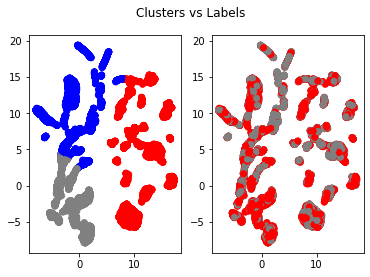

Test data


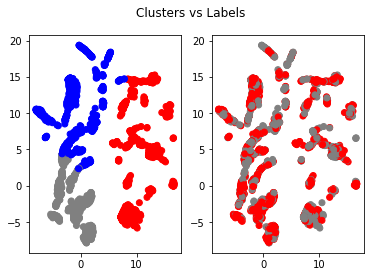

In [307]:
plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train, X_test, y_test)

# No Batch Local Hard Clusters

In [308]:
# Training separate models
args.lr = 0.002
classifiers = [NNClassifier(args, model.ae) for _ in range(args.n_clusters)]
# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 700
device = 'cpu'
model.eval()


qs, latents_X = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
X_latents_data_loader = list(zip(torch.FloatTensor(np.array(X_train)).to(args.device),\
                                 cluster_id_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

qs, latents_test = model(torch.FloatTensor(np.array(X_test)).to(args.device), output="latent")
q_test = qs[0]
cluster_id_test = torch.argmax(q_test, axis=1)
# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

X_train = torch.FloatTensor(np.array(X_train)).to(args.device)
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    alpha = (1-e/EPOCHS)
    acc = 0

    new_y = []
    y_pred = []
    for k in range(args.n_clusters):
        idx = np.where(cluster_id_train == k)[0]
        y_pred_idx, loss = classifiers[k].fit(X_train[idx], torch.tensor(y_train[idx]).to(device))
        y_pred.append(y_pred_idx)
        new_y.append(y_train[idx])
        epoch_loss += loss
#         print("Cluster: ", k, "F1: ", accuracy_score(np.argmax(y_pred_idx, axis=1), y_train[idx]), "loss: ", loss)
#         print(len(idx), np.argmax(y_pred_idx, axis=1))
#         print(y_pred_idx, y_train[idx])
    y_pred = np.vstack(y_pred)
    new_y = np.hstack(new_y)

    f1 = f1_score(np.argmax(y_pred, axis=1), new_y)
    acc = roc_auc_score(new_y, y_pred[:,1])
    epoch_acc += acc.item()
    epoch_f1 += f1.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    for k in range(args.n_clusters):
        classifiers[k].classifier.eval()
        idx = np.where(cluster_id_test == k)[0]
        latents_idx = latents_test[idx]
#         y_pred_idx = classifiers[k](latents_idx)
        y_pred_idx = classifiers[k](X_test[idx])
        test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test[idx]).to(device))
        test_preds.append(y_pred_idx.detach().numpy())
        new_y_test.append(y_test[idx])

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
    test_f1 = f1_score(np.argmax(test_preds, axis=1), new_y_test)
    test_acc = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| Test F1: {test_f1:.3f} | Test Acc: {test_acc:.3f} | Test Loss: {test_loss:.3f}')

Epoch 001: | Train Loss: 0.04392 | Train F1: 0.013 | Train Acc: 0.012| Test F1: 0.642 | Test Acc: 0.577 | Test Loss: 2.042
Epoch 002: | Train Loss: 0.04365 | Train F1: 0.013 | Train Acc: 0.012| Test F1: 0.642 | Test Acc: 0.583 | Test Loss: 2.031
Epoch 003: | Train Loss: 0.04345 | Train F1: 0.013 | Train Acc: 0.012| Test F1: 0.642 | Test Acc: 0.587 | Test Loss: 2.023
Epoch 004: | Train Loss: 0.04329 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.590 | Test Loss: 2.017
Epoch 005: | Train Loss: 0.04316 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.591 | Test Loss: 2.012
Epoch 006: | Train Loss: 0.04307 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.593 | Test Loss: 2.008
Epoch 007: | Train Loss: 0.04298 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.597 | Test Loss: 2.004
Epoch 008: | Train Loss: 0.04290 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.601 | Test Loss: 1.999
Epoch 009: | Tra

Epoch 069: | Train Loss: 0.04182 | Train F1: 0.010 | Train Acc: 0.013| Test F1: 0.506 | Test Acc: 0.616 | Test Loss: 1.964
Epoch 070: | Train Loss: 0.04181 | Train F1: 0.010 | Train Acc: 0.013| Test F1: 0.507 | Test Acc: 0.616 | Test Loss: 1.963
Epoch 071: | Train Loss: 0.04180 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.507 | Test Acc: 0.616 | Test Loss: 1.963
Epoch 072: | Train Loss: 0.04179 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.509 | Test Acc: 0.616 | Test Loss: 1.963
Epoch 073: | Train Loss: 0.04178 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.510 | Test Acc: 0.616 | Test Loss: 1.962
Epoch 074: | Train Loss: 0.04177 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.513 | Test Acc: 0.615 | Test Loss: 1.962
Epoch 075: | Train Loss: 0.04176 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.514 | Test Acc: 0.615 | Test Loss: 1.962
Epoch 076: | Train Loss: 0.04175 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.514 | Test Acc: 0.616 | Test Loss: 1.961
Epoch 077: | Tra

Epoch 136: | Train Loss: 0.04130 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.597 | Test Acc: 0.618 | Test Loss: 1.948
Epoch 137: | Train Loss: 0.04130 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.591 | Test Acc: 0.619 | Test Loss: 1.948
Epoch 138: | Train Loss: 0.04129 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.588 | Test Acc: 0.620 | Test Loss: 1.949
Epoch 139: | Train Loss: 0.04129 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.619 | Test Loss: 1.948
Epoch 140: | Train Loss: 0.04128 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.618 | Test Loss: 1.948
Epoch 141: | Train Loss: 0.04128 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.591 | Test Acc: 0.620 | Test Loss: 1.949
Epoch 142: | Train Loss: 0.04128 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.619 | Test Loss: 1.948
Epoch 143: | Train Loss: 0.04127 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.618 | Test Loss: 1.948
Epoch 144: | Tra

Epoch 204: | Train Loss: 0.04103 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.608 | Test Acc: 0.635 | Test Loss: 1.943
Epoch 205: | Train Loss: 0.04102 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.603 | Test Acc: 0.634 | Test Loss: 1.944
Epoch 206: | Train Loss: 0.04102 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.612 | Test Acc: 0.632 | Test Loss: 1.941
Epoch 207: | Train Loss: 0.04102 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.601 | Test Acc: 0.635 | Test Loss: 1.944
Epoch 208: | Train Loss: 0.04101 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.601 | Test Acc: 0.634 | Test Loss: 1.944
Epoch 209: | Train Loss: 0.04101 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.614 | Test Acc: 0.632 | Test Loss: 1.941
Epoch 210: | Train Loss: 0.04101 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.604 | Test Acc: 0.634 | Test Loss: 1.944
Epoch 211: | Train Loss: 0.04100 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.608 | Test Acc: 0.635 | Test Loss: 1.944
Epoch 212: | Tra

Epoch 272: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.610 | Test Acc: 0.640 | Test Loss: 1.938
Epoch 273: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.610 | Test Acc: 0.641 | Test Loss: 1.938
Epoch 274: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.610 | Test Acc: 0.641 | Test Loss: 1.938
Epoch 275: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.609 | Test Acc: 0.641 | Test Loss: 1.938
Epoch 276: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.611 | Test Acc: 0.640 | Test Loss: 1.937
Epoch 277: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.609 | Test Acc: 0.641 | Test Loss: 1.939
Epoch 278: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.613 | Test Acc: 0.640 | Test Loss: 1.937
Epoch 279: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.606 | Test Acc: 0.641 | Test Loss: 1.939
Epoch 280: | Tra

KeyboardInterrupt: 

# Embedding Classifier

In [108]:
# Training separate models
args.lr = 0.002
classifiers = [NNClassifier(args, input_dim=args.input_dim) for _ in range(1)]

# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 1000
device = 'cpu'
model.eval()

latents_X = model.ae(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

latents_test = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), output="latent")

# plot(latents_X, y_train, latents_test, y_test)

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    acc = 0

    new_y = []
    y_pred = []
    y_pred_idx, loss = classifiers[0].fit(latents_X, torch.tensor(y_train).to(device))
    y_pred.append(y_pred_idx)
    new_y.append(y_train)
    epoch_loss += loss
    y_pred = np.vstack(y_pred)
    new_y = np.hstack(new_y)

    acc = f1_score(np.argmax(y_pred, axis=1), new_y)
#     acc = roc_auc_score(new_y, y_pred[:,1])
    epoch_acc += acc.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    classifiers[0].classifier.eval()
    latents_idx = latents_test
    y_pred_idx = classifiers[0](latents_idx)
    test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test).to(device))
    test_preds.append(y_pred_idx.detach().numpy())
    new_y_test.append(y_test)

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
    test_f1 = f1_score(np.argmax(test_preds, axis=1), new_y_test)
#     test_f1 = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss:.5f} | Train Acc: {epoch_acc:.3f} | Test Acc: {test_f1:.3f} | Test Loss: {test_loss:.3f}')

out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())  

NameError: name 'cluster_id_train' is not defined

# Base Approch

In [18]:
print(X_train.shape)
m = NNClassifier(args, input_dim=args.input_dim)
print(m)
EPOCHS = 100
device = 'cpu'

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    alpha = (1-e/EPOCHS)
    acc = 0
    for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         latents = model.autoencoder(torch.FloatTensor(np.array(X_batch)).to(args.device), latent=True)
#         cluster_id = model.clustering.update_assign(latents.cpu().detach().numpy())
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score(np.argmax(y_pred, axis=1), y_batch.detach().numpy())
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()

    test_loss = 0.0

    m.classifier.eval()
    test_pred = m(torch.FloatTensor(np.array(X_test)).to(args.device))
    test_loss += nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.tensor(y_test).to(device))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
    test_acc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| Test F1: {test_f1:.3f} | Test Acc: {test_acc:.3f} | Test Loss: {test_loss:.3f}')


torch.Size([8943, 89])
NNClassifier(
  (criterion): CrossEntropyLoss()
  (classifier): Sequential(
    (0): Linear(in_features=89, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [16]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

In [22]:
igs = []
for i in range(args.n_clusters):
    ig = IntegratedGradients(classifiers[i])
    test_input_tensor = X_test
    test_input_tensor.requires_grad_()
    latents_X = model.ae(test_input_tensor, output="latent")
    attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
    attr = attr.detach().numpy()
    igs.append([ig, attr])

Average Feature Importances
SAPS-I :  -0.001
SOFA :  -0.000
Length_of_stay :  0.001
Age :  -0.001
Gender :  0.000
Height :  -0.002
Weight :  -0.001
CCU :  -0.002
CSRU :  0.000
SICU :  -0.001
DiasABP_first :  0.001
GCS_first :  -0.003
Glucose_first :  0.000
HR_first :  0.002
MAP_first :  0.002
NIDiasABP_first :  -0.000
NIMAP_first :  0.000
NISysABP_first :  0.001
RespRate_first :  -0.001
SaO2_first :  0.001
Temp_first :  0.001
DiasABP_last :  0.001
GCS_last :  0.007
Glucose_last :  0.000
HR_last :  0.000
MAP_last :  -0.000
NIDiasABP_last :  0.000
NIMAP_last :  0.003
NISysABP_last :  0.001
RespRate_last :  -0.004
SaO2_last :  0.001
Temp_last :  0.001
DiasABP_lowest :  0.001
GCS_lowest :  0.001
Glucose_lowest :  0.000
HR_lowest :  0.000
MAP_lowest :  -0.001
NIDiasABP_lowest :  0.000
NIMAP_lowest :  0.001
NISysABP_lowest :  0.003
RespRate_lowest :  -0.003
SaO2_lowest :  0.000
Temp_lowest :  0.003
DiasABP_highest :  0.001
GCS_highest :  0.010
Glucose_highest :  0.000
HR_highest :  0.002
MAP

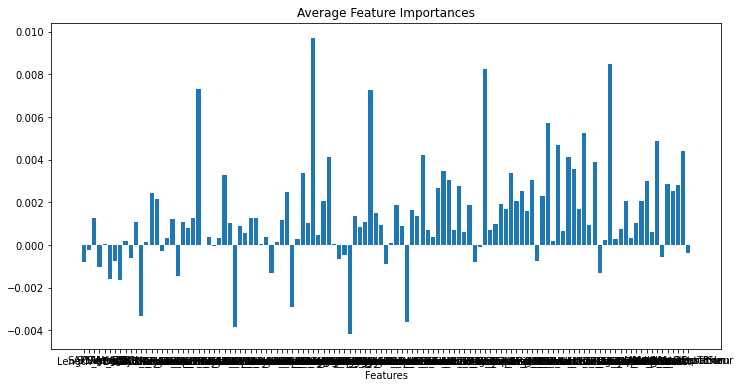

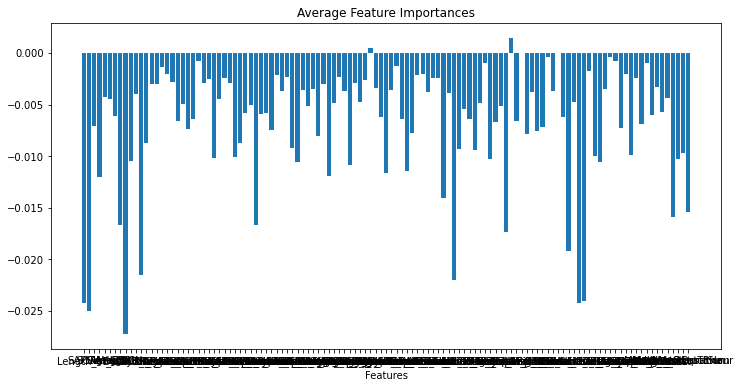

In [23]:
# for k in range(args.n_clusters):
#     idx = np.where(cluster_batch == k)[0]
#     y_pred_idx, loss = classifiers[k].fit(X_batch[idx], y_batch[idx])


for k in range(args.n_clusters):
    classifiers[k].classifier.eval()
    idx = np.where(cluster_id_train == k)[0]
    X_train_idx = torch.FloatTensor(np.array(X_train)).to(args.device)[idx]
    y_pred_idx = classifiers[k](X_train_idx)
    visualize_importances(columns, np.mean(igs[k][1], axis=0))